# A simple stochastic example

At the end of the notebook that discusses the stochastic simulator and GP emulation of it, we discuss some options for extending the [MOGP Emulator](https://mogp-emulator.readthedocs.io/en/latest/) package.
Before working on such a task, we require a simple test problem.
In this notebook, we explore a stochastic version of the code from one of their tutorials.

In [2]:
import mogp_emulator
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp

%matplotlib widget

## Simulator code

We will use an amended version of the [tutorial](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) from the MOGP documentation as our example.
- Measurement error is added to the output, as $\mathcal{N}(0, 20)$. (Later, we will make this vary with distance)
- Optionally, one of the two inputs (drag coefficient and initial velocity) can be held constant.

In [3]:
def f(t, y, c):
    "Compute RHS of system of differential equations, returning vector derivative"

    # check inputs and extract

    assert len(y) == 4
    assert c >= 0.

    vx = y[0]
    vy = y[1]

    # calculate derivatives

    dydt = np.zeros(4)

    dydt[0] = -c*vx*np.sqrt(vx**2 + vy**2)
    dydt[1] = -9.8 - c*vy*np.sqrt(vx**2 + vy**2)
    dydt[2] = vx
    dydt[3] = vy

    return dydt

def event(t, y, c):
    "event to trigger end of integration"

    assert len(y) == 4
    assert c >= 0.

    return y[3]

event.terminal = True

def simulator(x, c=None, v0=None, error_sigma=None, error_changepoint=None):
    "simulator to solve ODE system for projectile motion with drag. returns distance projectile travels"

    assert len(x) == 1 or len(x) == 2
    if error_changepoint is not None:
        assert error_sigma is not None

    # unpack values
    if len(x) == 2 and c is None and v0 is None:
        c = 10.**x[0]
        v0 = x[1]
    elif len(x) == 1 and isinstance(c, float) and v0 is None:
        c = 10.**c
        v0 = x[0]
    elif len(x) == 1 and c is None and isinstance(v0, float):
        c = 10.**x[0]
    else:
        raise Exception("Expected x of length 2, or of length 1 with one of c or v0 specified")
    
    assert v0 > 0.

    # set initial conditions
    y0 = np.zeros(4)

    y0[0] = v0/np.sqrt(2.)
    y0[1] = v0/np.sqrt(2.)
    y0[3] = 2.

    # run simulation
    results = solve_ivp(f, (0., 1.e8), y0, events=event, args = (c,))
    
    distance = results.y_events[0][0][2]
    if error_sigma is not None:
        measurement_error = np.random.normal(0, error_sigma)
        if error_changepoint is not None:
            measurement_error = measurement_error * distance / error_changepoint
        distance = distance + measurement_error

    return distance

def print_results(inputs, predictions):
    "convenience function for printing out results and computing mean square error"

    print("Target Point                   Predicted mean            Actual Value")
    print("------------------------------------------------------------------------------")

    error = 0.

    for pp, m in zip(inputs, predictions):
        trueval = simulator(pp)
        print("{}      {}       {}".format(pp, m, simulator(pp)))
        error += (trueval - m)**2

    print("\nMean squared error: {}".format(np.sqrt(error)/len(predictions)))    

## Fit and validate an example GP

Use two parameters, and in this case we'll only take one sample at each design point.
This should let us fit a GP without any numerical issues (although we may not see a particularly good fit yet).

In [4]:
# Choose our design points
lhd = mogp_emulator.LatinHypercubeDesign([(-5., 1.), (0., 1000.)])

# Perform 50 simulations with an imperfect measurement system (noise of N(0,20) at each point)
n_simulations = 50
simulation_points = lhd.sample(n_simulations)
simulation_output = np.array([simulator(p, error_sigma=20) for p in simulation_points])

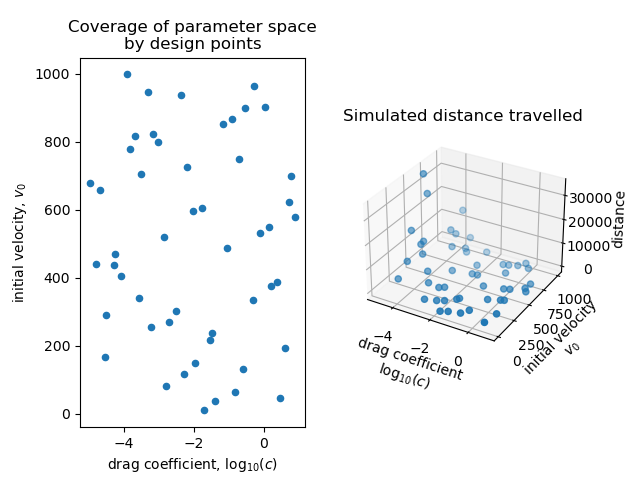

In [5]:
# Plot the distribution of the design points
fig_ex_gp = plt.figure()

ax_ex_gp_design = fig_ex_gp.add_subplot(1,2,1)
ax_ex_gp_design.scatter(simulation_points[:,0], simulation_points[:,1], s=20)
plt.xlabel("drag coefficient, $\log_{10}(c)$")
plt.ylabel("initial velocity, $v_0$")
plt.title("Coverage of parameter space\nby design points");

ax_ex_gp_train = fig_ex_gp.add_subplot(1,2,2,projection='3d')
ax_ex_gp_train.scatter(simulation_points[:,0], simulation_points[:,1], simulation_output)
ax_ex_gp_train.set_xlabel("drag coefficient\n$\log_{10}(c)$")
ax_ex_gp_train.set_ylabel("initial velocity\n$v_0$")
ax_ex_gp_train.set_zlabel("distance")
plt.title("Simulated distance travelled");

In [6]:
# Fit the GP
gp = mogp_emulator.GaussianProcess(simulation_points, simulation_output)
gp = mogp_emulator.fit_GP_MAP(gp)

print("Correlation lengths = {}".format(np.sqrt(np.exp(-gp.theta[:2]))))
print("Sigma = {}".format(np.sqrt(np.exp(gp.theta[2]))))

Floating point error in optimization routine, skipping this iteration
Floating point error in optimization routine, skipping this iteration
Correlation lengths = [  1.04847394 517.02169571]
Sigma = 15369.867216096955


In [7]:
# Validate the GP
n_valid = 10
validation_points = lhd.sample(n_valid)
validation_output = np.array([simulator(p) for p in validation_points])

predictions = gp.predict(validation_points)

print_results(validation_points, predictions.mean)

Target Point                   Predicted mean            Actual Value
------------------------------------------------------------------------------
[-6.13097189e-02  9.71320434e+01]      -565.3406399853993       3.961461509576963
[  0.55047681 527.85393359]      7.642720144009218       1.450142687730488
[ -2.24014694 868.35823569]      486.9729858560313       548.536022467554
[ -4.35841698 667.1459483 ]      19677.441179315876       19767.39830044711
[ -4.41491299 743.96148392]      23024.83561041936       23505.804427747207
[-2.60927590e-01  9.87577919e+02]      31.099657369341003       8.987446672153139
[ -3.58363002 196.40902836]      3756.2312230959215       2297.1149329059454
[ -3.06158084 281.07951775]      1536.2327081568365       1653.8093820442386
[ -1.55614144 358.04729541]      -9.135455126524903       110.96861868563353
[ -0.85002796 411.63001757]      112.59548420034116       26.918319203934967

Mean squared error: 165.30141144869714


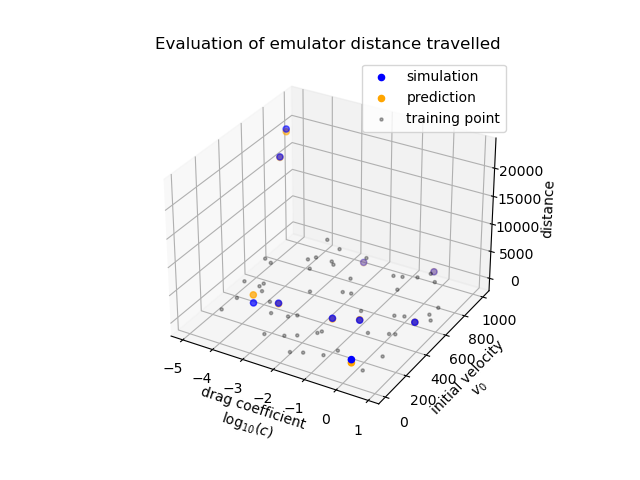

In [8]:
fig_ex = plt.figure()
ax_ex_gp = fig_ex.add_subplot(1,1,1,projection='3d')
ax_ex_gp.scatter(validation_points[:,0], validation_points[:,1], validation_output, c="blue")
ax_ex_gp.scatter(validation_points[:,0], validation_points[:,1], predictions.mean, c="orange")
ax_ex_gp.scatter(simulation_points[:,0], simulation_points[:,1], np.zeros_like(simulation_points[:,0]), c="black", marker=".", alpha=0.3)
# ax_ex_gp.scatter(validation_points[:,0], validation_points[:,1], predictions.mean + predictions.unc, c="orange", marker=".")
# ax_ex_gp.scatter(validation_points[:,0], validation_points[:,1], predictions.mean - predictions.unc, c="orange", marker=".")

ax_ex_gp.set_xlabel("drag coefficient\n$\log_{10}(c)$")
ax_ex_gp.set_ylabel("initial velocity\n$v_0$")
ax_ex_gp.set_zlabel("distance")
plt.legend(["simulation", "prediction", "training point"])
plt.title("Evaluation of emulator distance travelled");

After re-running the section above several times, the influence of the initial training points is very apparent.
Ranges of <100 to over 1000 have been generated for the mean squared error (given just above the previous figure), with the largest errors being linked to validation points outside of the initial design points.

## One-parameter simulation with repeated design points

We'll now perform several runs of the simulation at each design point, so that we get some constant noise on our results (distance travelled).

In [9]:
# Choose our design points for v0 only
lhd = mogp_emulator.LatinHypercubeDesign([(0., 1000.)])

# Perform 50 simulations x 5 repeats with c fixed at 0.1
n_simulations = 50
n_repeats = 5
const_c = -2.0
simulation_points = np.repeat(lhd.sample(n_simulations), n_repeats, axis=0)
simulation_output = np.array([simulator(p, c=const_c, error_sigma=20) for p in simulation_points])

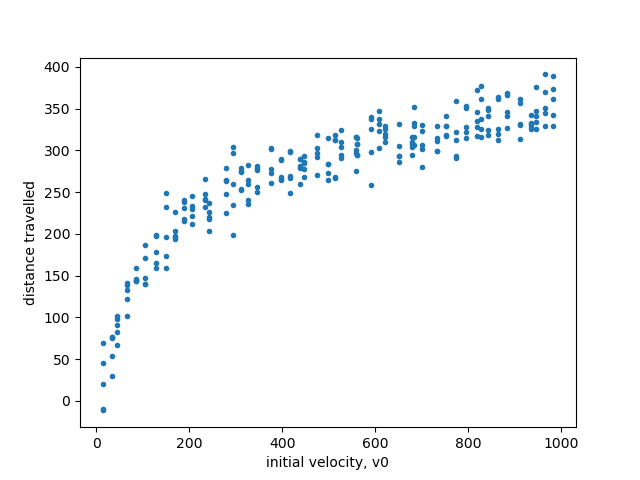

In [10]:
fig_one_par = plt.figure()

plt.scatter(simulation_points, simulation_output, marker=".");
plt.xlabel("initial velocity, v0");
plt.ylabel("distance travelled");

In [11]:
# Fit the GPs

gpa = mogp_emulator.GaussianProcess(simulation_points, simulation_output, nugget="adaptive")
gpa = mogp_emulator.fit_GP_MAP(gpa)

gpf = mogp_emulator.GaussianProcess(simulation_points, simulation_output, nugget="fit")
gpf = mogp_emulator.fit_GP_MAP(gpf)

print("Correlation lengths (adaptive) = {}".format(np.sqrt(np.exp(-gpa.theta[:2]))))
print("Sigma (adaptive) = {}".format(np.sqrt(np.exp(gpa.theta[2]))))

print("Correlation lengths (fit) = {}".format(np.sqrt(np.exp(-gpf.theta[:2]))))
print("Sigma (fit) = {}".format(np.sqrt(np.exp(gpf.theta[2]))))

Correlation lengths (adaptive) = [6.10521808e+02 7.59229644e-04]
Sigma (adaptive) = 1.076672543217969
Correlation lengths (fit) = [3.16113950e+02 2.92891895e-03]
Sigma (fit) = 19.712631313016498


In [12]:
# Validate the GPs
# Note on the include_nugget flag: we set it to False here as our nugget is being used to capture the obervational error

n_valid = 20
validation_points = lhd.sample(n_valid)
validation_output = np.array([simulator(p, c=const_c) for p in validation_points])
validation_order = np.argsort(validation_points.flatten())    # used for plotting later

predictionsa = gpa.predict(validation_points, include_nugget=False)
predictionsf = gpf.predict(validation_points, include_nugget=False)

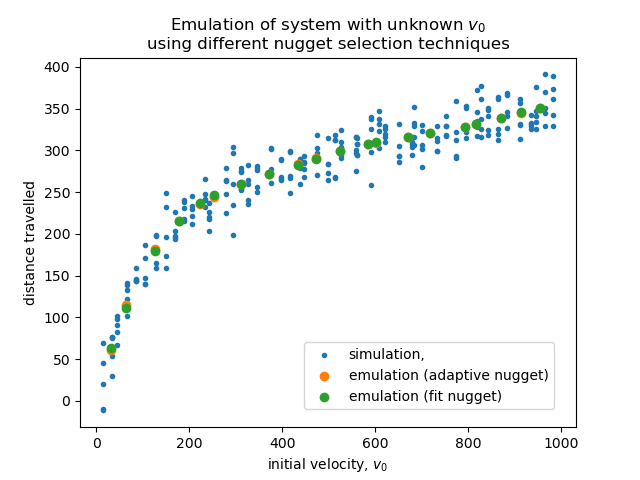

In [13]:
fig_one_par_gp = plt.figure()

plt.scatter(simulation_points, simulation_output, marker=".");
plt.scatter(validation_points, predictionsa.mean);
plt.scatter(validation_points, predictionsf.mean);
plt.xlabel("initial velocity, $v_0$");
plt.ylabel("distance travelled");
plt.title("Emulation of system with unknown $v_0$\nusing different nugget selection techniques")
plt.legend(labels=["simulation,", "emulation (adaptive nugget)", "emulation (fit nugget)"], loc="lower right", bbox_to_anchor=(0.97,0.03));

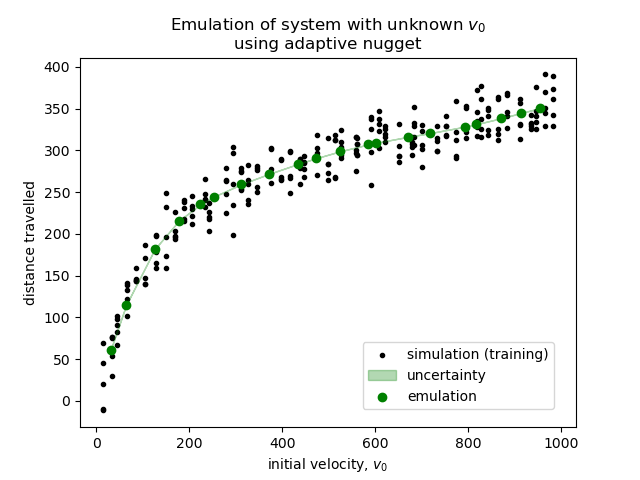

In [14]:
fig_one_par_a = plt.figure()

uppera = predictionsa.mean + predictionsa.unc
lowera = predictionsa.mean - predictionsa.unc

plt.scatter(simulation_points, simulation_output, marker=".", color="k");
plt.fill_between(validation_points.flatten()[validation_order], lowera[validation_order], uppera[validation_order], alpha=0.3, color="g");
plt.scatter(validation_points, predictionsa.mean, marker="o", color="g");
plt.xlabel("initial velocity, $v_0$");
plt.ylabel("distance travelled");
plt.title("Emulation of system with unknown $v_0$\nusing adaptive nugget")
plt.legend(labels=["simulation (training)", "uncertainty", "emulation"], loc="lower right", bbox_to_anchor=(0.97,0.03));

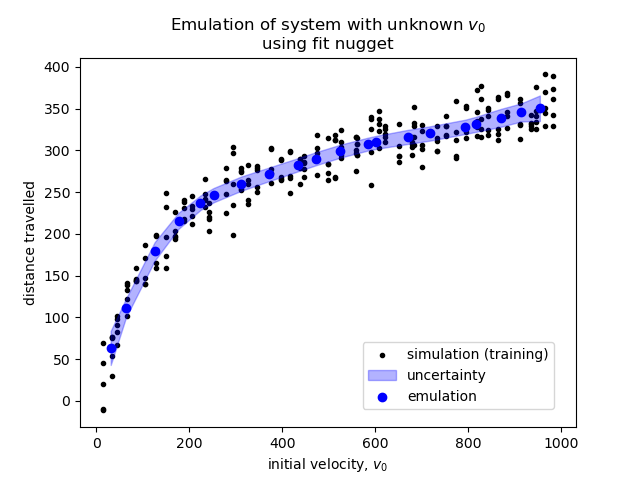

In [15]:
fig_one_par_f = plt.figure()

upperf = predictionsf.mean + predictionsf.unc
lowerf = predictionsf.mean - predictionsf.unc

plt.scatter(simulation_points, simulation_output, marker=".", color="k");
plt.fill_between(validation_points.flatten()[validation_order], lowerf[validation_order], upperf[validation_order], alpha=0.3, color="b");
plt.scatter(validation_points, predictionsf.mean, marker="o", color="b");
plt.xlabel("initial velocity, $v_0$");
plt.ylabel("distance travelled");
plt.title("Emulation of system with unknown $v_0$\nusing fit nugget")
plt.legend(labels=["simulation (training)", "uncertainty", "emulation"], loc="lower right", bbox_to_anchor=(0.97,0.03));

## One-parameter simulation with repeated design points and non-constant noise

Let's now extend the stochasticity in the model beyond a simple constant noise term on the final measurement.
We'll perform the same analysis as in the previous section, but make the noise dependent on the distance travelled: the measurement will become less accurate the further the projectile goes.

In [16]:
# Choose our design points for v0 only
lhd_ncn = mogp_emulator.LatinHypercubeDesign([(0., 1000.)])

# Perform 50 simulations x 5 repeats with c fixed at 0.1
n_simulations = 50
n_repeats = 5
const_c = -2.0
simulation_points_ncn = np.repeat(lhd.sample(n_simulations), n_repeats, axis=0)
simulation_output_ncn = np.array([simulator(p, c=const_c, error_sigma=20, error_changepoint=300) for p in simulation_points_ncn])

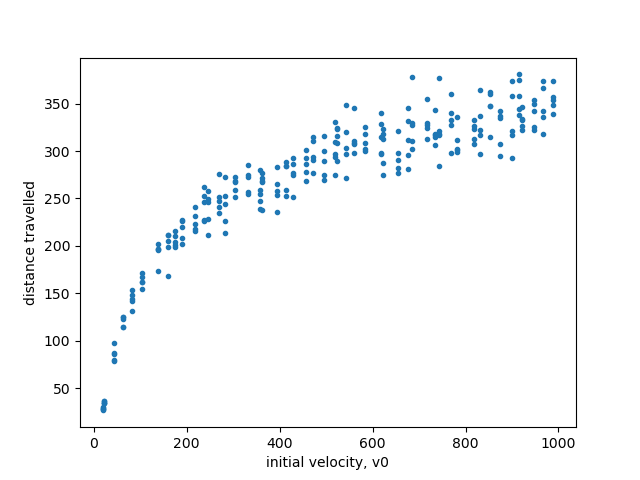

In [17]:
fig_ncn = plt.figure()

plt.scatter(simulation_points_ncn, simulation_output_ncn, marker=".");
plt.xlabel("initial velocity, v0");
plt.ylabel("distance travelled");

In [18]:
gpf_ncn = mogp_emulator.GaussianProcess(simulation_points_ncn, simulation_output_ncn, nugget="fit")
gpf_ncn = mogp_emulator.fit_GP_MAP(gpf_ncn)

print("Correlation lengths (fit) = {}".format(np.sqrt(np.exp(-gpf_ncn.theta[:2]))))
print("Sigma (fit) = {}".format(np.sqrt(np.exp(gpf_ncn.theta[2]))))

Floating point error in optimization routine, skipping this iteration
Floating point error in optimization routine, skipping this iteration
Correlation lengths (fit) = [3.07061618e+02 2.68092830e-03]
Sigma (fit) = 17.966582520419895


In [19]:
n_valid = 20
validation_points_ncn = lhd_ncn.sample(n_valid)
validation_output_ncn = np.array([simulator(p, c=const_c) for p in validation_points_ncn])
validation_order_ncn = np.argsort(validation_points_ncn.flatten())    # used for plotting later

predictionsf_ncn = gpf_ncn.predict(validation_points_ncn, include_nugget=False)

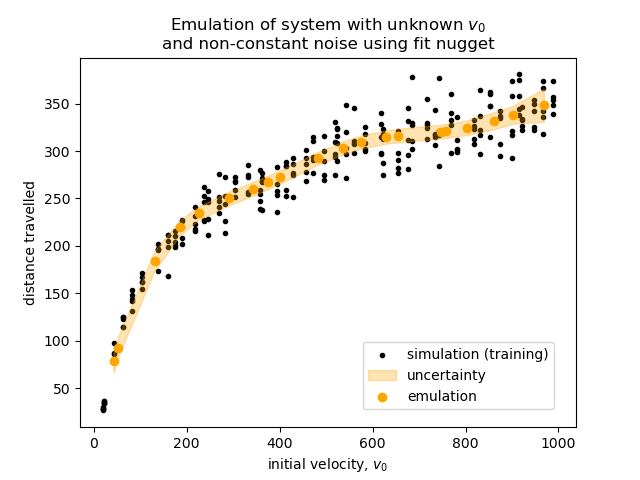

In [20]:
fig_ncn_f = plt.figure()

upperf_ncn = predictionsf_ncn.mean + predictionsf_ncn.unc
lowerf_ncn = predictionsf_ncn.mean - predictionsf_ncn.unc

plt.scatter(simulation_points_ncn, simulation_output_ncn, marker=".", color="k");
plt.fill_between(validation_points_ncn.flatten()[validation_order_ncn], lowerf_ncn[validation_order_ncn], upperf_ncn[validation_order_ncn], alpha=0.3, color="orange");
plt.scatter(validation_points_ncn, predictionsf_ncn.mean, marker="o", color="orange");
plt.xlabel("initial velocity, $v_0$");
plt.ylabel("distance travelled");
plt.title("Emulation of system with unknown $v_0$\nand non-constant noise using fit nugget")
plt.legend(labels=["simulation (training)", "uncertainty", "emulation"], loc="lower right", bbox_to_anchor=(0.97,0.03));

The uncertainty estimate appears similar to that in the previous section, despite the noise being markedly different as the value of $v_0$ changes.
We will therefore need a more advanced way of modelling the noise if we are to use a GP to emulate this system.

## One-parameter GP with non-constant noise and non-repeated design points

A quick check here to see what effect non-repeated design points have on the uncertainty bounds.
We'll use two numbers of design points: the total number used in the set above, and the total number of $v_0$ values from the set above (i.e. without the repeats).

In [21]:
# Use the lhd from the previous section
simulation_points_nrd = lhd.sample(n_simulations)
simulation_points_nrd_rep = lhd.sample(n_simulations * n_repeats)

simulation_output_nrd = np.array([simulator(p, c=const_c, error_sigma=20, error_changepoint=300) for p in simulation_points_nrd])
simulation_output_nrd_rep = np.array([simulator(p, c=const_c, error_sigma=20, error_changepoint=300) for p in simulation_points_nrd_rep])

In [22]:
gpf_nrd = mogp_emulator.GaussianProcess(simulation_points_nrd, simulation_output_nrd, nugget="fit")
gpf_nrd = mogp_emulator.fit_GP_MAP(gpf_nrd)

gpf_nrd_rep = mogp_emulator.GaussianProcess(simulation_points_nrd_rep, simulation_output_nrd_rep, nugget="fit")
gpf_nrd_rep = mogp_emulator.fit_GP_MAP(gpf_nrd_rep)

print("Correlation lengths ({} points) = {}".format(n_simulations, np.sqrt(np.exp(-gpf_nrd.theta[:2]))))
print("Sigma ({} points) = {}".format(n_simulations, np.sqrt(np.exp(gpf_nrd.theta[2]))))

print("Correlation lengths ({} points) = {}".format(n_simulations * n_repeats, np.sqrt(np.exp(-gpf_nrd_rep.theta[:2]))))
print("Sigma ({} points) = {}".format(n_simulations * n_repeats, np.sqrt(np.exp(gpf_nrd_rep.theta[2]))))

Correlation lengths (50 points) = [3.88501848e+02 3.52004277e-03]
Sigma (50 points) = 21.09848332731382
Correlation lengths (250 points) = [2.74807633e+02 3.10598243e-03]
Sigma (250 points) = 18.985466651816157


In [23]:
n_valid = 20
validation_points_nrd = lhd_ncn.sample(n_valid)
validation_output_nrd = np.array([simulator(p, c=const_c) for p in validation_points_nrd])
validation_order_nrd = np.argsort(validation_points_nrd.flatten())    # used for plotting later

predictionsf_nrd = gpf_nrd.predict(validation_points_nrd, include_nugget=False)
predictionsf_nrd_rep = gpf_nrd_rep.predict(validation_points_nrd, include_nugget=False)

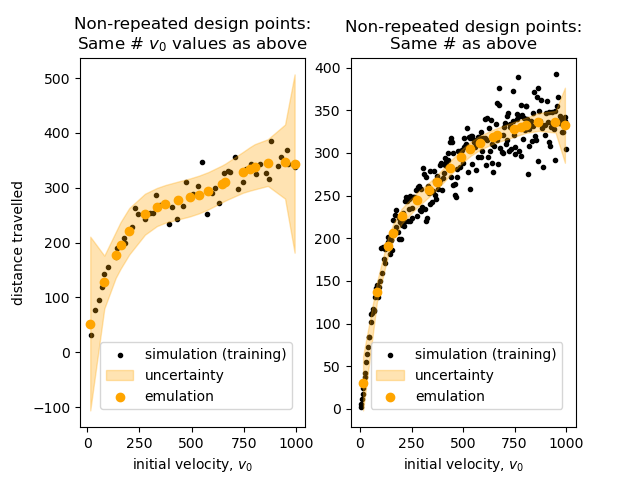

In [24]:
fig_nrd = plt.figure()

upperf_nrd = predictionsf_nrd.mean + predictionsf_nrd.unc
lowerf_nrd = predictionsf_nrd.mean - predictionsf_nrd.unc

ax_nrd = fig_nrd.add_subplot(1,2,1)
plt.scatter(simulation_points_nrd, simulation_output_nrd, marker=".", color="k");
plt.fill_between(validation_points_nrd.flatten()[validation_order_nrd], lowerf_nrd[validation_order_nrd], upperf_nrd[validation_order_nrd], alpha=0.3, color="orange");
plt.scatter(validation_points_nrd, predictionsf_nrd.mean, marker="o", color="orange");
plt.xlabel("initial velocity, $v_0$");
plt.ylabel("distance travelled");
plt.title("Non-repeated design points:\nSame # $v_0$ values as above")
plt.legend(labels=["simulation (training)", "uncertainty", "emulation"], loc="lower right", bbox_to_anchor=(0.97,0.03));

upperf_nrd_rep = predictionsf_nrd_rep.mean + predictionsf_nrd_rep.unc
lowerf_nrd_rep = predictionsf_nrd_rep.mean - predictionsf_nrd_rep.unc

ax_nrd = fig_nrd.add_subplot(1,2,2)
plt.scatter(simulation_points_nrd_rep, simulation_output_nrd_rep, marker=".", color="k");
plt.fill_between(validation_points_nrd.flatten()[validation_order_nrd], lowerf_nrd_rep[validation_order_nrd], upperf_nrd_rep[validation_order_nrd], alpha=0.3, color="orange");
plt.scatter(validation_points_nrd, predictionsf_nrd_rep.mean, marker="o", color="orange");
plt.xlabel("initial velocity, $v_0$");
plt.title("Non-repeated design points:\nSame # as above")
plt.legend(labels=["simulation (training)", "uncertainty", "emulation"], loc="lower right", bbox_to_anchor=(0.97,0.03));